In [1]:
import ast
import pandas as pd
import numpy as np
from utils import *

from nltk.tokenize.treebank import TreebankWordDetokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Conv1D, Dropout, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import tensorflow.random as random

seed = 111
random.set_seed(seed)
np.random.seed(seed)

In [2]:
df = pd.read_csv("cleaned_data/cleaned_reviews_3.csv")
df["text"] = df["text"].apply(lambda x: ast.literal_eval(x))
df["detoken"] = df["text"].apply(lambda y: TreebankWordDetokenizer().tokenize(y))
df.head()

,review,text,rating,sentiment,detoken
0,"This started out strong, but it went downhill ...","[start, out, strong, but, go, downhill, fairly...",1,0,start out strong but go downhill fairly quickl...
1,"A decently written YA book, but I can't even c...","[decently, write, ya, book, but, can, even, co...",1,0,decently write ya book but can even consider e...
2,"Ugh...I tried, I honestly tried. I'm a huge fa...","[ugh, try, honestly, try, huge, fan, scott, we...",1,0,ugh try honestly try huge fan scott westerfeld...
3,Main points: \n 1. Never ever introduce a poin...,"[main, point, never, ever, introduce, point, v...",1,0,main point never ever introduce point view sid...
4,Why do all YA books have to have a love triang...,"[all, ya, book, love, triangle, now, just, who...",1,0,all ya book love triangle now just whole world...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     11400 non-null  object
 1   text       11400 non-null  object
 2   rating     11400 non-null  int64 
 3   sentiment  11400 non-null  int64 
 4   detoken    11400 non-null  object
dtypes: int64(2), object(3)
memory usage: 445.4+ KB


In [4]:
df_pos, df_neg = split_sentiment(df)
df_train, df_test = split_train_test(df_pos, df_neg, 222)

train_words = [word for text in df_train["text"] for word in text]
train_text_length = [len(text) for text in df_train["text"]]

vocab = list(set(train_words))
vocab_size = len(vocab)

print(f"There are {len(train_words)} train words in total and the vocabulary size is {vocab_size}.")

There are 515575 train words in total and the vocabulary size is 18590.


In [5]:
train_data = df_train["detoken"].tolist()
test_data = df_test["detoken"].tolist()

tokenizer = Tokenizer(num_words=15000)
tokenizer.fit_on_texts(train_data)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

# max_length = max(max([len(x) for x in train_sequences]), max([len(x) for x in test_sequences]))
max_length = 150

x_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post")
x_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post")

ytrain, ytest = np.asarray(df_train["sentiment"]), np.asarray(df_test["sentiment"])

print(max_length)
print(x_train_padded.shape)
print(x_test_padded.shape)
print(ytrain.shape)
print(ytest.shape)
print(f"Found {len(word_index)} unique tokens")

150
(9120, 150)
(2280, 150)
(9120,)
(2280,)
Found 18616 unique tokens


In [6]:
embeddings_dict = {}
with open("glove.42B.300d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [7]:
vocab_train = vocab_build(df_train["text"])
vocab_test = vocab_build(df_test["text"])

train_covered, train_oov, train_vocab_coverage, train_text_coverage = embedding_coverage(df_train["text"], embeddings_dict)
test_covered, test_oov, test_vocab_coverage, test_text_coverage = embedding_coverage(df_test["text"], embeddings_dict)

print(f"Glove embeddings cover {round(train_vocab_coverage, 2)}% of vocabulary and {round(train_text_coverage, 2)}% text in training set")
print(f"Glove embeddings cover {round(test_vocab_coverage, 2)}% of vocabulary and {round(test_text_coverage, 2)}% text in testing set")

Glove embeddings cover 95.22% of vocabulary and 99.79% text in training set
Glove embeddings cover 97.13% of vocabulary and 99.76% text in testing set


In [8]:
EMBEDDING_DIM = 300
MAX_WORDS = 15000
vocab_size = min(len(word_index) + 1, MAX_WORDS)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    
    try:
        embedding_vector = embeddings_dict[word]
        embedding_matrix[i] = embedding_vector
    
    except KeyError:
        embedding_vector = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length, trainable=False)

del(embedding_matrix)

### Model CNN

In [42]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(64, 5, activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          4500000   
                                                                 
 conv1d_11 (Conv1D)          (None, 146, 64)           96064     
                                                                 
 dropout_22 (Dropout)        (None, 146, 64)           0         
                                                                 
 global_max_pooling1d_11 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                     

In [43]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/5
114/114 [==============================] - 4s 32ms/step - loss: 0.4984 - accuracy: 0.7574 - val_loss: 0.4096 - val_accuracy: 0.8383
Epoch 2/5
114/114 [==============================] - 4s 32ms/step - loss: 0.3214 - accuracy: 0.8672 - val_loss: 0.3480 - val_accuracy: 0.8591
Epoch 3/5
114/114 [==============================] - 4s 34ms/step - loss: 0.2464 - accuracy: 0.9041 - val_loss: 0.5535 - val_accuracy: 0.7582
Epoch 4/5
114/114 [==============================] - 4s 35ms/step - loss: 0.1599 - accuracy: 0.9419 - val_loss: 0.5256 - val_accuracy: 0.7812
Epoch 5/5
114/114 [==============================] - 4s 34ms/step - loss: 0.1059 - accuracy: 0.9664 - val_loss: 0.3419 - val_accuracy: 0.8596


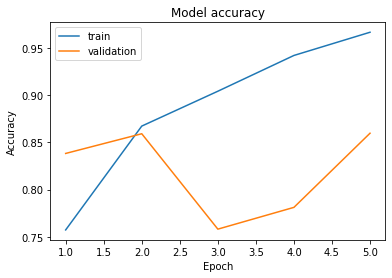

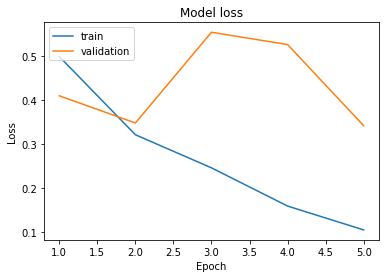

72/72 - 0s - loss: 0.3332 - accuracy: 0.8596 - 465ms/epoch - 6ms/step
Test accuracy: 0.859649121761322
Confusion matrix: 
 [[971 169]
 [151 989]]
Test accuracy: 0.8596491228070176


In [44]:
# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

_y_pred = model.predict(x_test_padded)
y_pred = np.round(_y_pred)

print(f"Confusion matrix: \n {confusion_matrix(ytest, y_pred)}")
print(f"Test accuracy: {accuracy_score(ytest, y_pred)}")